ERA 5 (HORARIO A MENSUAL)

C:\Users\ANALY AVALOS\AppData\Local\Temp\ipykernel_20352\2777151795.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_month = df.groupby(pd.Grouper(key="fecha", freq="M")).sum(numeric_only=True)


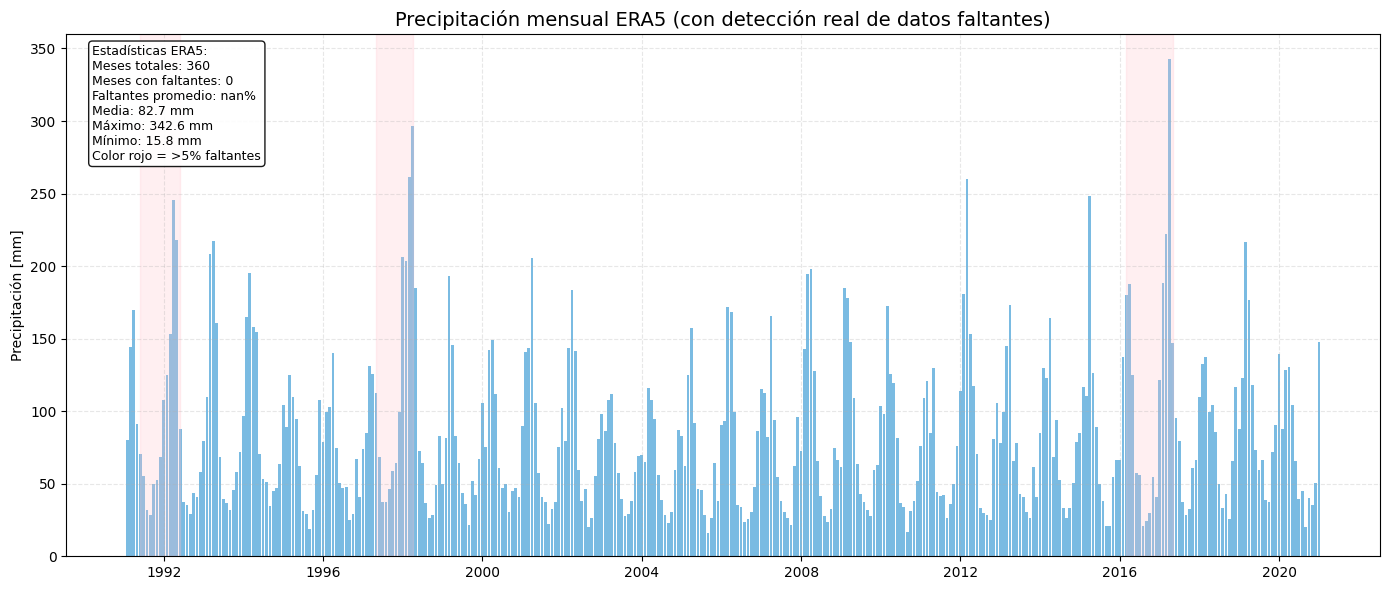

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# 
ds = xr.open_dataset(r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\datos_era_1991_2020.nc")

var = list(ds.data_vars)[0]  
df = ds[var].to_dataframe().reset_index()

# 
time_col = [c for c in df.columns if "time" in c.lower()][0]
df["fecha"] = pd.to_datetime(df[time_col])

# 
df["precip_mm"] = df[var] 

# 

# 
df["year"] = df["fecha"].dt.year
df["month"] = df["fecha"].dt.month
df["days_in_month"] = df["fecha"].dt.days_in_month

# conteo de datos por mes
df_count = df.groupby(["year", "month"]).agg(
    datos_presentes=("precip_mm", "count"),
    dias=("days_in_month", "first")
).reset_index()

# ERA5 horario 
df_count["datos_esperados"] = df_count["dias"] * 24

# porcentaje de datos faltantes
df_count["faltantes_%"] = 100 * (1 - df_count["datos_presentes"] / df_count["datos_esperados"])

# índice mensual para unir con mensualizado
df_count["fecha"] = pd.to_datetime(df_count["year"].astype(str) + "-" +
                                   df_count["month"].astype(str) + "-01")

# 
df_month = df.groupby(pd.Grouper(key="fecha", freq="M")).sum(numeric_only=True)

# unir info de faltantes con mensual
df_month = df_month.merge(df_count[["fecha", "faltantes_%"]],
                          left_index=True, right_on="fecha", how="left").set_index("fecha")

# medidas estadisticas
total = len(df_month)
missing_months = (df_month["faltantes_%"] > 0).sum()
mean_missing = df_month["faltantes_%"].mean()

precip_mean = df_month["precip_mm"].mean()
precip_max = df_month["precip_mm"].max()
precip_min = df_month["precip_mm"].min()

#graficos
plt.figure(figsize=(14, 6))

# pintar barras  segun % faltantes
colors = df_month["faltantes_%"].apply(lambda x: "red" if x > 5 else "#4EA5D9")

plt.bar(df_month.index, df_month["precip_mm"], width=25, alpha=0.75, color=colors)

# sombreados de eventos El Niño
eventos_nino = [
    ("1991-06-01", "1992-06-01"),
    ("1997-05-01", "1998-04-01"),
    ("2016-03-01", "2017-05-01")
]

for inicio, fin in eventos_nino:
    plt.axvspan(pd.to_datetime(inicio), pd.to_datetime(fin), alpha=0.25, color="pink")

# cuadro de estadisticas
stats_text = (
    f"Estadísticas ERA5:\n"
    f"Meses totales: {total}\n"
    f"Meses con faltantes: {missing_months}\n"
    f"Faltantes promedio: {mean_missing:.2f}%\n"
    f"Media: {precip_mean:.1f} mm\n"
    f"Máximo: {precip_max:.1f} mm\n"
    f"Mínimo: {precip_min:.1f} mm\n"
    f"Color rojo = >5% faltantes"
)

plt.text(
    0.02, 0.98, stats_text,
    transform=plt.gca().transAxes, fontsize=9, va="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
)

plt.title("Precipitación mensual ERA5 (con detección real de datos faltantes)", fontsize=14)
plt.ylabel("Precipitación [mm]")
plt.grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()


c:\Users\ANALY AVALOS\TP2\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


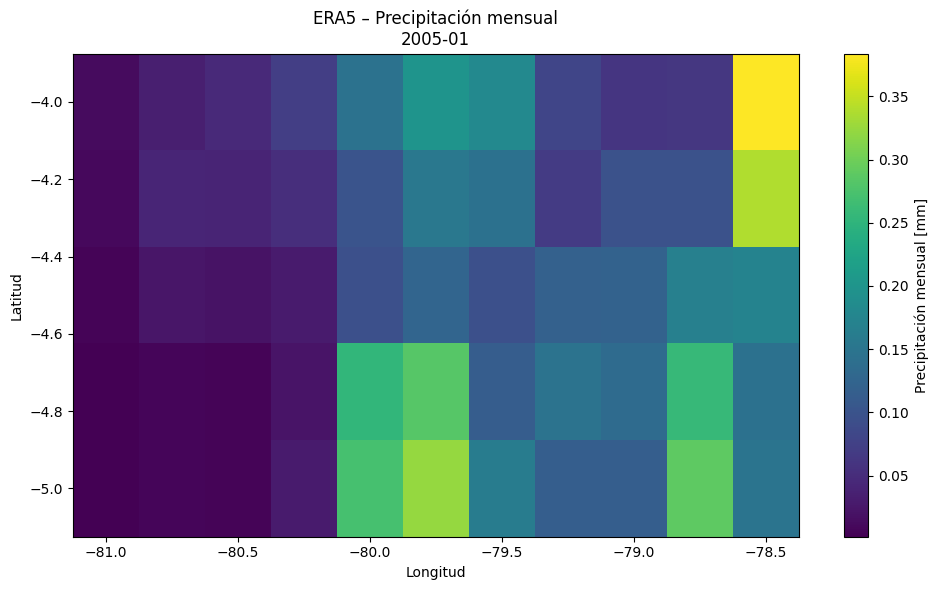

In [7]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# 1. Cargar archivo ERA5
# ============================
ds = xr.open_dataset(r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\datos_era_1991_2020.nc")

# Detectar nombre de time
time_name = "time" if "time" in ds.coords else "valid_time"
var = list(ds.data_vars)[0]

# ============================
# 2. Convertir a mensual
# ============================
data_mm = (ds[var] * 1).resample({time_name: "1M"}).sum()

# ============================
# 3. Elegir año y mes
# ============================
anio = 2005
mes = 1

campo = data_mm.sel({time_name: f"{anio}-{mes:02d}"})

# Quitar dimensión sobrante (1, lat, lon)
campo2d = campo.squeeze()

# ============================
# 4. Graficar
# ============================
plt.figure(figsize=(10, 6))
plt.pcolormesh(campo2d["longitude"], campo2d["latitude"], campo2d, shading="auto")
plt.colorbar(label="Precipitación mensual [mm]")
plt.title(f"ERA5 – Precipitación mensual\n{anio}-{mes:02d}")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.tight_layout()
plt.show()


PISCO 

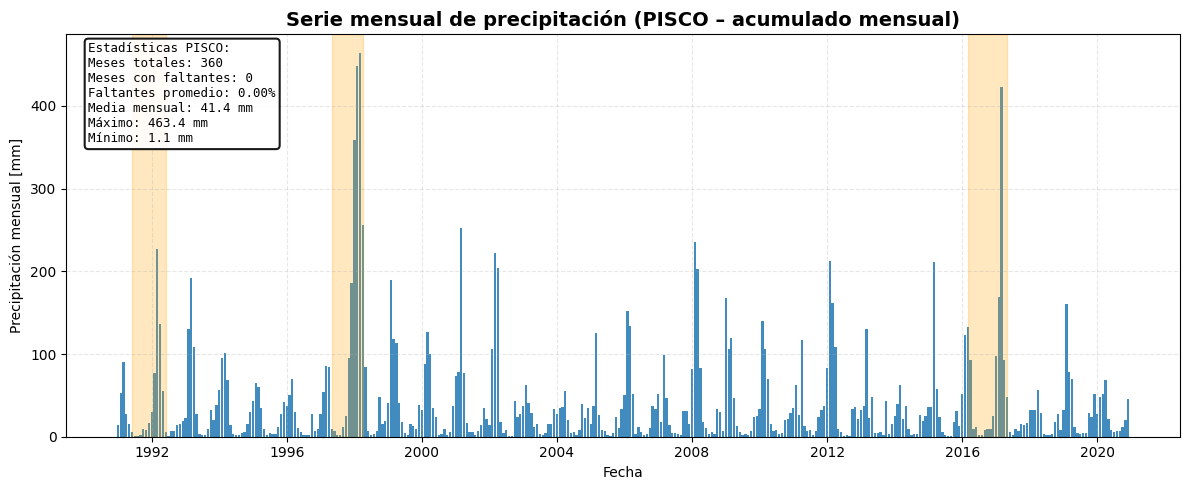

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from dateutil.relativedelta import relativedelta

# leer archivos
ds = xr.open_dataset(
    r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\PISCO_Peru_1991_2020.nc",
    decode_times=False
)

# variable
var = "Prec"

# se hace un promedio espacial para obtener la serie temporal
serie = ds[var].mean(dim=("X", "Y")).to_dataframe().reset_index()

# se reconstruye el tiempo
time_col = "T"
time_raw = ds[time_col].values

units = ds[time_col].attrs["units"]    # "months since 1960-01-01"
base_date = pd.to_datetime(units.split("since")[1].strip())

# reconstruir fechas
fechas = [base_date + relativedelta(months=int(t)) for t in time_raw]
serie["fecha"] = fechas

# renombramos la columna de precipitacion
serie = serie.rename(columns={var: "precip_mm"})

# ahora detectamos la presencia de datos faltantes

# si un mes tiene NaN,se considera el porcentaje
serie["is_nan"] = serie["precip_mm"].isna().astype(int)

total = len(serie)                     # total de meses
missing_months = serie["is_nan"].sum() # número de meses con NA
mean_missing = (missing_months / total) * 100  # %

precip_mean = serie["precip_mm"].mean()
precip_max = serie["precip_mm"].max()
precip_min = serie["precip_mm"].min()

# se usa esto para sombrear de rojo con los datos faltantes

colors = serie["precip_mm"].apply(lambda x: "red" if pd.isna(x) else "C0")

# grafico

plt.figure(figsize=(12, 5))

plt.bar(serie["fecha"], serie["precip_mm"], 
        width=25, alpha=0.85, color=colors)

# destacamos al niño
eventos_nino = [
    ("1991-06-01", "1992-06-01"),
    ("1997-05-01", "1998-04-01"),
    ("2016-03-01", "2017-05-01")
]

for inicio, fin in eventos_nino:
    plt.axvspan(pd.to_datetime(inicio),
                pd.to_datetime(fin),
                alpha=0.25, color="orange")

plt.title("Serie mensual de precipitación (PISCO – acumulado mensual)", 
          fontsize=14, fontweight="bold")
plt.xlabel("Fecha")
plt.ylabel("Precipitación mensual [mm]")
plt.grid(True, alpha=0.3, linestyle="--")

# cuadro de estadisticas
stats_text = (
    f"Estadísticas PISCO:\n"
    f"Meses totales: {total}\n"
    f"Meses con faltantes: {missing_months}\n"
    f"Faltantes promedio: {mean_missing:.2f}%\n"
    f"Media mensual: {precip_mean:.1f} mm\n"
    f"Máximo: {precip_max:.1f} mm\n"
    f"Mínimo: {precip_min:.1f} mm"
)

plt.text(
    0.02, 0.98, stats_text, transform=plt.gca().transAxes,
    fontsize=9, va="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9,
              edgecolor="black", linewidth=1.5),
    family="monospace"
)

plt.tight_layout()
plt.show()


ESTACIONES

In [9]:
import pandas as pd

# columnas
col_names = ["anio", "mes", "dia", "pp", "tmax", "tmin"]

# leer archivo
df = pd.read_csv(
    r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000230ESPERANZA.txt",
    sep=r"\s+",
    header=None,
    names=col_names
)

print("Primeras filas:")
print(df.head())

# contamos los -99.9
missing_999 = (df == -99.9).sum()

print("\nConteo de valores -99.9 por columna:")
print(missing_999)

# se pasa a porcentaje
percent_999 = (missing_999 / len(df)) * 100

print("\nPorcentaje de -99.9 por columna (%):")
print(percent_999.round(2))

#total
total_missing = missing_999.sum()
total_values = df.size
percent_total = (total_missing / total_values) * 100

print(f"\nTotal de -99.9 en todo el dataset: {total_missing}")
print(f"Porcentaje total de -99.9: {percent_total:.2f}%")


Primeras filas:
   anio  mes  dia    pp  tmax  tmin
0  1966    7    1 -99.9  30.0  17.0
1  1966    7    2 -99.9  29.0  15.7
2  1966    7    3 -99.9  25.5  13.5
3  1966    7    4 -99.9  29.0  15.5
4  1966    7    5 -99.9  26.0  14.5

Conteo de valores -99.9 por columna:
anio      0
mes       0
dia       0
pp      869
tmax    340
tmin    513
dtype: int64

Porcentaje de -99.9 por columna (%):
anio    0.00
mes     0.00
dia     0.00
pp      4.82
tmax    1.89
tmin    2.85
dtype: float64

Total de -99.9 en todo el dataset: 1722
Porcentaje total de -99.9: 1.59%


In [10]:
import pandas as pd
import os
import numpy as np

archivos = [
    r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000247SANMIGUEL.txt",
    r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000230ESPERANZA.txt",
    r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\SIqc00000237AYABACA.txt"
]

col_names = ["anio", "mes", "dia", "pp", "tmax", "tmin"]
resumen = []

for file_path in archivos:

    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)

    print("\n--- Archivo leído:", file_path)
    print(df.head())
    print("Shape:", df.shape)

    # corregir tipos
    df["anio"] = pd.to_numeric(df["anio"], errors="coerce")
    df["mes"]  = pd.to_numeric(df["mes"], errors="coerce")
    df["dia"]  = pd.to_numeric(df["dia"], errors="coerce")

    # modificamos la fecha
    df["fecha"] = pd.to_datetime(
        df["anio"].astype("Int64").astype(str) + "-" +
        df["mes"].astype("Int64").astype(str).str.zfill(2) + "-" +
        df["dia"].astype("Int64").astype(str).str.zfill(2),
        errors="coerce"
    )

    # converimos de -99.9 a NAN
    df.replace(-99.9, np.nan, inplace=True)

    # contabilizamos los faltantes
    missing_pp = df["pp"].isna().sum()
    total_filas = len(df)
    percent_pp = (missing_pp / total_filas) * 100

    total_values = df.size
    percent_total = (missing_pp / total_values) * 100

    # exportamos a csv
    csv_path = file_path.replace(".txt", ".csv")
    df.to_csv(csv_path, index=False)

    resumen.append({
        "estacion": os.path.basename(file_path),
        "total_filas": total_filas,
        "faltantes_pp": missing_pp,
        "%faltantes_pp": round(percent_pp, 2),
        "%faltantes_total_dataset": round(percent_total, 4),
        "csv_generado": csv_path
    })

# vizualizacion de datos en resumen
resumen_df = pd.DataFrame(resumen)
print("\n=== RESUMEN FINAL ===")
print(resumen_df)



--- Archivo leído: C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000247SANMIGUEL.txt
   anio  mes  dia    pp  tmax  tmin
0  1973    1    1  0.00  33.0 -99.9
1  1973    1    2  0.01  33.5 -99.9
2  1973    1    3  0.00  32.3 -99.9
3  1973    1    4  0.00  31.5 -99.9
4  1973    1    5  0.00  34.0 -99.9
Shape: (15644, 6)

--- Archivo leído: C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000230ESPERANZA.txt
   anio  mes  dia    pp  tmax  tmin
0  1966    7    1 -99.9  30.0  17.0
1  1966    7    2 -99.9  29.0  15.7
2  1966    7    3 -99.9  25.5  13.5
3  1966    7    4 -99.9  29.0  15.5
4  1966    7    5 -99.9  26.0  14.5
Shape: (18020, 6)

--- Archivo leído: C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\SIqc00000237AYABACA.txt
   anio  mes  dia   pp  tmax  tmin
0  1963    1    1  0.0  21.0   6.0
1  1963    1    2  0.0  21.0   6.0
2  1963    1    3  0.0  21.0   8.0
3  1963    1    4  0.0  21.5   6.0
4  1963    1    5  0.0  21.5   6.5
Shape: (1880

In [14]:
# resumen final
resumen_df = pd.DataFrame(resumen)
print("\n=== RESUMEN FINAL ===")
print(resumen_df)


=== RESUMEN FINAL ===
                     estacion  total_filas  faltantes_pp  %faltantes_pp  \
0   COqc00000247SANMIGUEL.txt        15644           609           3.89   
1  COqc00000207MIRAFLORES.txt        15615           908           5.81   
2     SIqc00000237AYABACA.txt        18809           674           3.58   

   %faltantes_total_dataset                                       csv_generado  
0                    0.5561  C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\S...  
1                    0.8307  C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\S...  
2                    0.5119  C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\S...  


In [11]:
import pandas as pd

ruta = r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000247SANMIGUEL.csv"

df = pd.read_csv(ruta)

print("Columnas encontradas en el archivo:")
print(df.columns.tolist())

print("\nPrimeras filas:")
print(df.head())


Columnas encontradas en el archivo:
['anio', 'mes', 'dia', 'pp', 'tmax', 'tmin', 'fecha']

Primeras filas:
   anio  mes  dia    pp  tmax  tmin       fecha
0  1973    1    1  0.00  33.0   NaN  1973-01-01
1  1973    1    2  0.01  33.5   NaN  1973-01-02
2  1973    1    3  0.00  32.3   NaN  1973-01-03
3  1973    1    4  0.00  31.5   NaN  1973-01-04
4  1973    1    5  0.00  34.0   NaN  1973-01-05


C:\Users\ANALY AVALOS\AppData\Local\Temp\ipykernel_20352\2473247846.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.resample("M", on="fecha").agg({
C:\Users\ANALY AVALOS\AppData\Local\Temp\ipykernel_20352\2473247846.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.resample("M", on="fecha").agg({
C:\Users\ANALY AVALOS\AppData\Local\Temp\ipykernel_20352\2473247846.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.resample("M", on="fecha").agg({


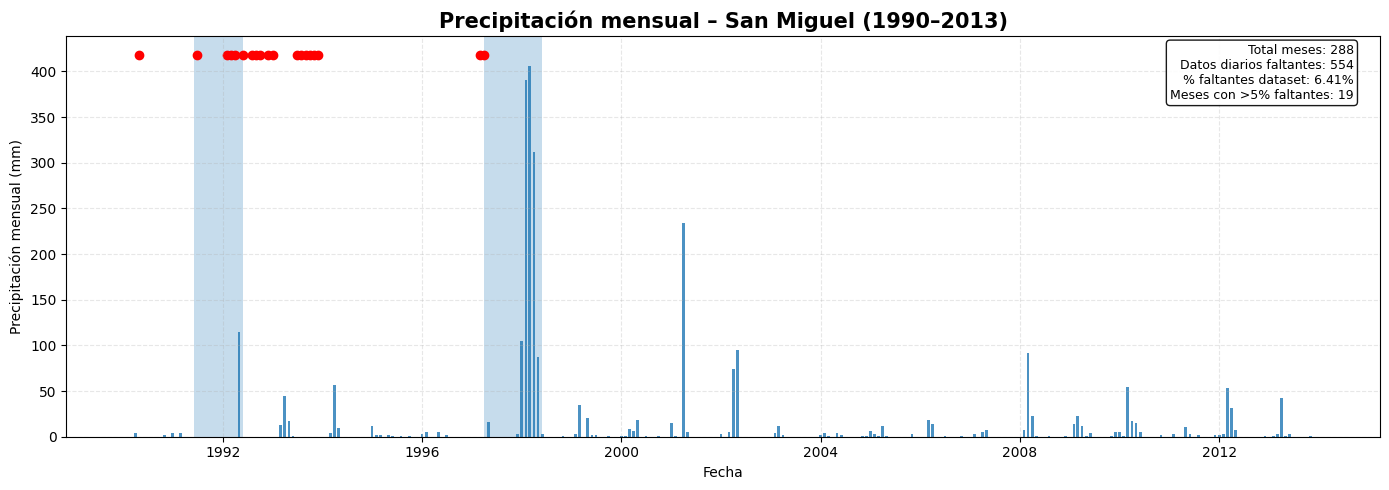

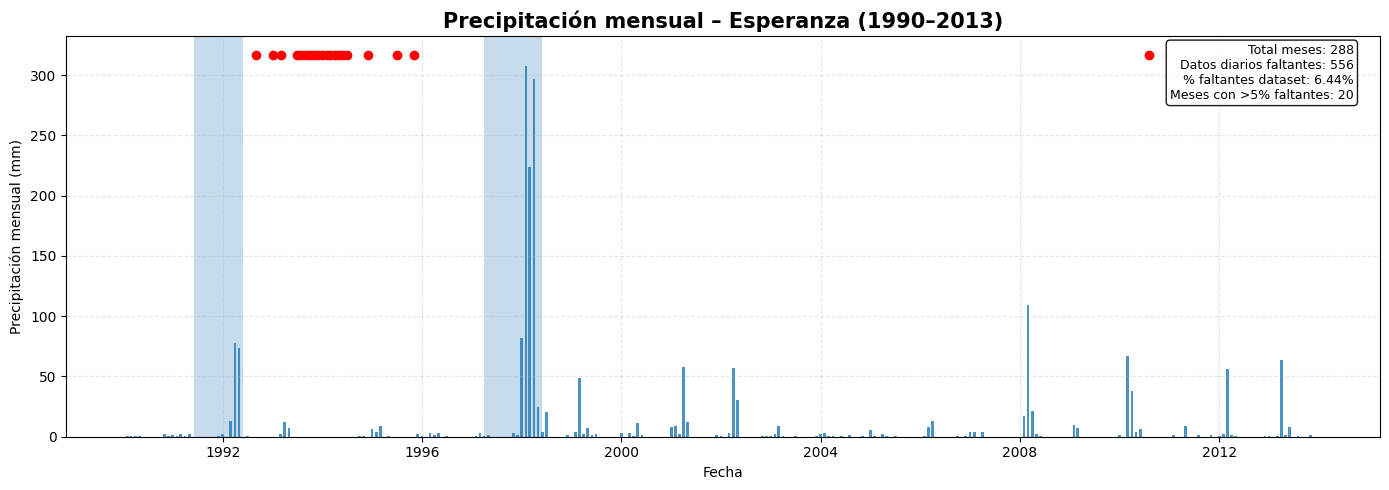

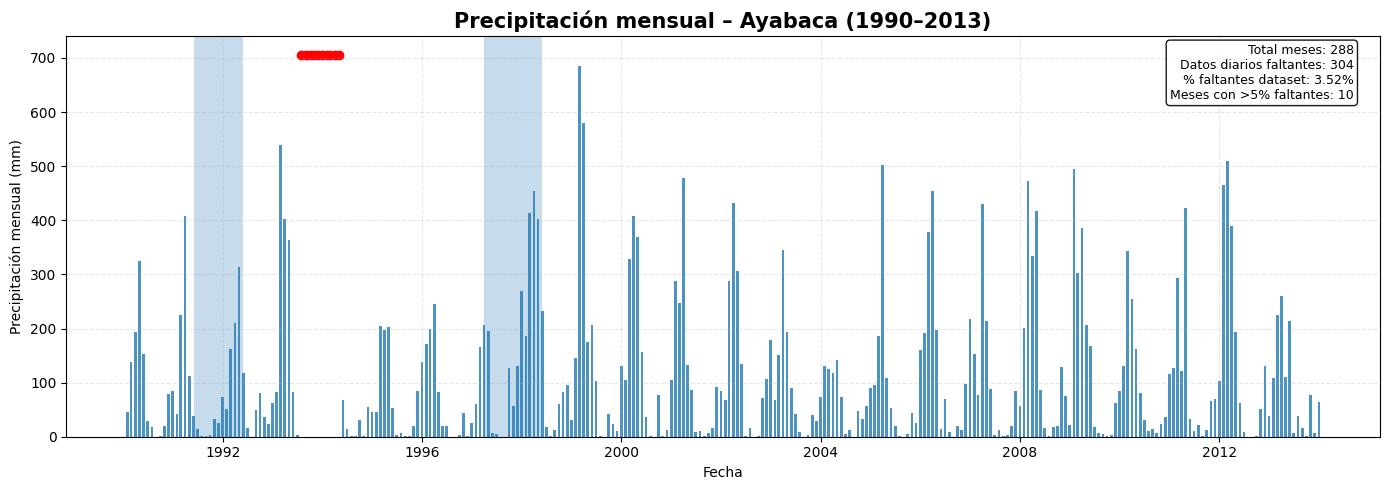

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

#  cargamos las estaciones
files = {
    "San Miguel": r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000247SANMIGUEL.csv",
    "Esperanza": r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000230ESPERANZA.csv",
    "Ayabaca": r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\SIqc00000237AYABACA.csv"
}

dfs = {}

for name, path in files.items():
    df = pd.read_csv(path)

    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
    df = df[(df["fecha"] >= "1990-01-01") & (df["fecha"] <= "2013-12-31")]
    df["pp"] = pd.to_numeric(df["pp"], errors="coerce")

    dfs[name] = df

# pasamos a meses, mensulizamos
mensuales = {}

for name, df in dfs.items():

    m = df.resample("M", on="fecha").agg({
        "pp": "sum",
        "fecha": lambda x: df.loc[x.index, "pp"].isna().sum()
    }).rename(columns={"fecha": "nan_count"})

    m["days_in_month"] = m["nan_count"].index.days_in_month  
    m["nan_pct"] = (m["nan_count"] / m["days_in_month"]) * 100

    mensuales[name] = m.reset_index()

# sombreamos algunos eventos El Niño
eventos_nino = [
    ("1991-06-01", "1992-06-01"),
    ("1997-04-01", "1998-06-01")
]

eventos_nino = [(pd.to_datetime(i), pd.to_datetime(f)) for i, f in eventos_nino]

# graficamos
for estacion, df in mensuales.items():

    total_months = len(df)
    total_missing = df["nan_count"].sum()
    pct_missing_dataset = (total_missing / (total_months * 30)) * 100  # aproximado

    plt.figure(figsize=(14, 5))

    plt.bar(df["fecha"], df["pp"], width=20, alpha=0.8)

    for inicio, fin in eventos_nino:
        plt.axvspan(inicio, fin, alpha=0.25)

    faltantes = df[df["nan_pct"] > 5]
    plt.scatter(faltantes["fecha"], 
                [df["pp"].max()*1.03]*len(faltantes), 
                color="red", 
                label=">5% faltantes")

    plt.title(f"Precipitación mensual – {estacion} (1990–2013)", 
              fontsize=15, fontweight="bold")
    plt.xlabel("Fecha")
    plt.ylabel("Precipitación mensual (mm)")
    plt.grid(alpha=0.3, linestyle="--")

    stats_text = (
        f"Total meses: {total_months}\n"
        f"Datos diarios faltantes: {total_missing}\n"
        f"% faltantes dataset: {pct_missing_dataset:.2f}%\n"
        f"Meses con >5% faltantes: {len(faltantes)}"
    )

    # ubicacion del cuadro de estadisticas
    plt.text(
        0.98, 0.98, stats_text,
        transform=plt.gca().transAxes,
        fontsize=9, va="top", ha="right",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9,
                  edgecolor="black"),
    )

    plt.tight_layout()
    plt.show()


CLIMATOLOGÍA POR ESTACIÓN 

ESTACIÓN MIRAFLORES Y SAN MIGUEL : COSTA

ESTACIÓN AYABACA : SIERRA

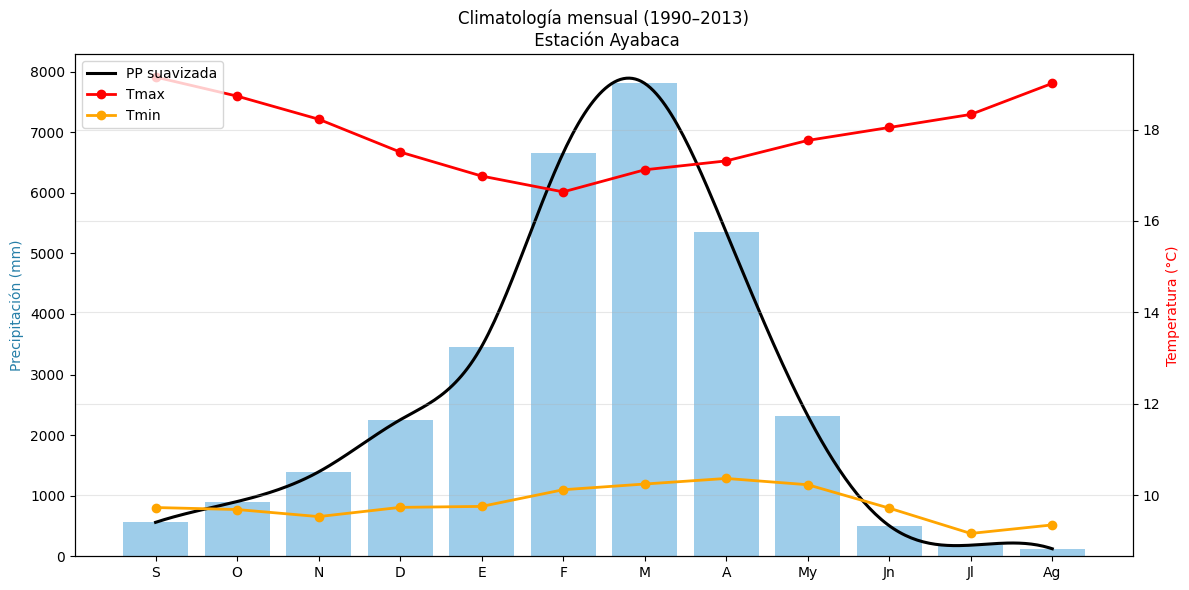

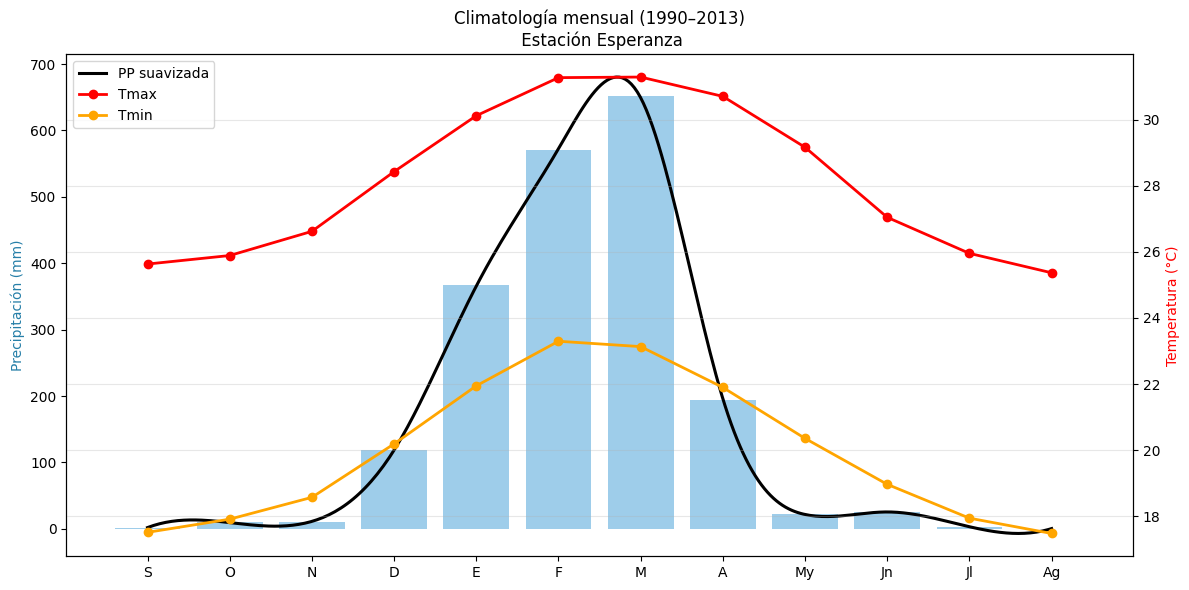

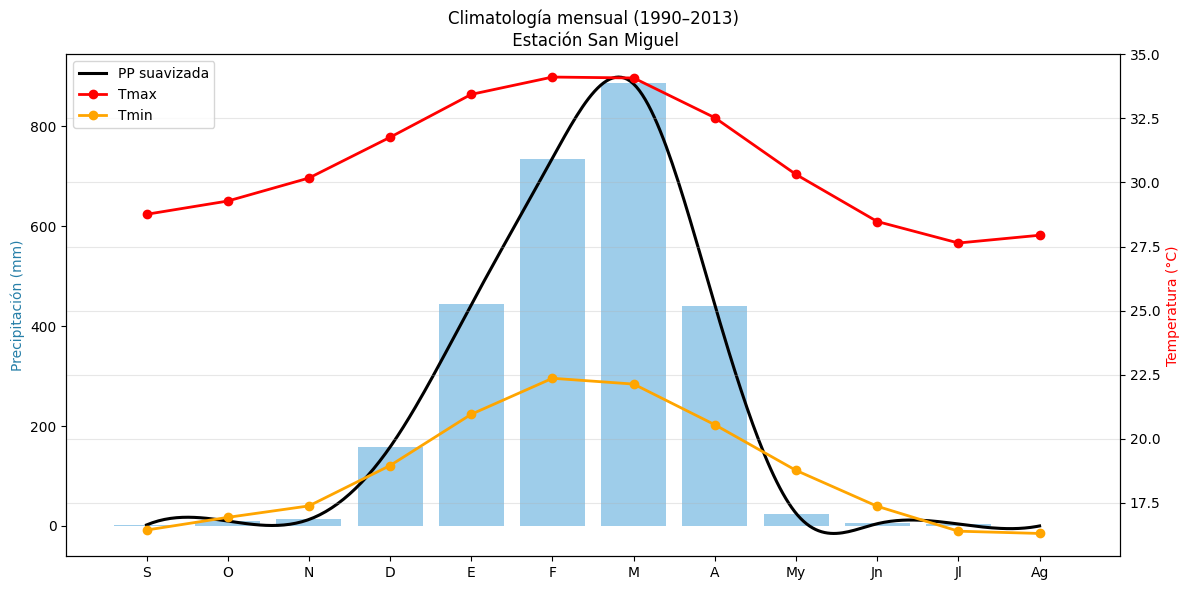

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline



import pandas as pd

# cargamos las estaciones
files = {
    "San Miguel": r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000247SANMIGUEL.csv",
    "Esperanza": r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\COqc00000230ESPERANZA.csv",
    "Ayabaca":    r"C:\Users\ANALY AVALOS\Documents\UNALM\2025-2\SEQUIA\OFFII\SIqc00000237AYABACA.csv"
}

dfs = []

for estacion, path in files.items():
    df = pd.read_csv(path)

    # se normalizan los nombres de columnas
    df.columns = df.columns.str.lower()

    # se coloca en dataframe los nombres de columnas esperados
    df["fecha"] = pd.to_datetime(df["fecha"])
    df["anio"] = df["fecha"].dt.year
    df["mes"] = df["fecha"].dt.month

    df["estacion"] = estacion
    dfs.append(df)

# unimos todos los datos
data = pd.concat(dfs, ignore_index=True)

# calculamos la climatología
climatologia = (
    data[(data["anio"] >= 1990) & (data["anio"] <= 2013)]
    .groupby(["estacion", "mes"])
    .agg({
        "pp": "sum",      
        "tmax": "mean",
        "tmin": "mean"
    })
    .reset_index()
)
# ordenamos los meses de septiembre a agosto
mapeo = {
    9:  "S",
    10: "O",
    11: "N",
    12: "D",
    1:  "E",
    2:  "F",
    3:  "M",
    4:  "A",
    5:  "My",
    6:  "Jn",
    7:  "Jl",
    8:  "Ag"
}

orden_meses = ["S", "O", "N", "D", "E", "F", "M", "A", "My", "Jn", "Jl", "Ag"]

# procesamos por estación en bucle

for estacion in climatologia["estacion"].unique():
    
    df_est = climatologia[climatologia["estacion"] == estacion].copy()

    df_est["mes_label"] = df_est["mes"].map(mapeo)
    df_est["orden"] = df_est["mes_label"].apply(lambda x: orden_meses.index(x))
    df_est = df_est.sort_values("orden")

    # ordenamos datos
    x = np.arange(12)

    pp_vals = df_est["pp"].values
    tmax_vals = df_est["tmax"].values
    tmin_vals = df_est["tmin"].values

    # suavizams las lineas de precipitación
    spline_pp = UnivariateSpline(x, pp_vals, s=20)

    # suavizado constante
    x_smooth = np.linspace(0, 11, 300)

    # graficamos
    plt.figure(figsize=(12, 6))

    # Precipitación en gráfica de barras
    ax1 = plt.gca()
    ax1.bar(df_est["mes_label"], pp_vals, color="#4EA5D9", alpha=0.55)
    ax1.set_ylabel("Precipitación (mm)", color="#267FA8")

    # Curva suavizada de precipitación
    ax1.plot(x_smooth, spline_pp(x_smooth),
             color="black", linewidth=2.2, label="PP suavizada")

    # nuevo eje para temperaturas
    ax2 = ax1.twinx()

    # tmax
    ax2.plot(df_est["mes_label"], tmax_vals, marker="o",
             color="red", linewidth=2, label="Tmax")
    # tmin
    ax2.plot(df_est["mes_label"], tmin_vals, marker="o",
         color="orange", linewidth=2, label="Tmin")

    ax2.set_ylabel("Temperatura (°C)", color="red")
    # titulo
    plt.title(f"Climatología mensual (1990–2013)\n Estación {estacion}")

    # Leyenda 
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    plt.legend(l1 + l2, lab1 + lab2, loc="upper left")

    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()